# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]

    X = X.T
    for i in range(X.shape[0]):
        col_min, col_max = X[i].min(), X[i].max()
        X[i] = (X[i] - col_min) / (col_max - col_min)

    return X.T, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.linalg.norm(y_predicted - y_true) / len(y_true)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    y_mean = y_true.mean()
    return 1 - np.linalg.norm(y_predicted - y_true) / np.linalg.norm(y_predicted - y_mean)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        pass


    def __extend(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X = self.__extend(X)

        self.__w = np.linalg.inv(X.T @ X) @ X.T @ y
    

    def predict(self, X:np.ndarray) -> np.ndarray:
        X = self.__extend(X)

        return X @ self.__w

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.006542067269602292, R2: 0.968513457440295


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.__lr = alpha
        self.__n_iter = iterations
        self.__l = l


    def __extend(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    
    def __init_weights(self, X):
        np.random.seed(42)
        self.W = np.random.normal(0, 0.01, (X.shape[1],))


    def fit(self, X:np.ndarray, y:np.ndarray):
        X = self.__extend(X)
        self.__init_weights(X)
        priv_grad = 0

        for i in range(self.__n_iter):
            y_pred = X @ self.W
            grad_W = (-(y - y_pred) @ X + self.__l * np.sign(self.W)) / len(y)

            if np.linalg.norm(priv_grad - grad_W) < 1e-08:
                break

            self.W -= self.__lr * grad_W
            
            priv_grad = grad_W
        

    def predict(self, X:np.ndarray):
        X = self.__extend(X)
        y_pred = X @ self.W

        return y_pred

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [23]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

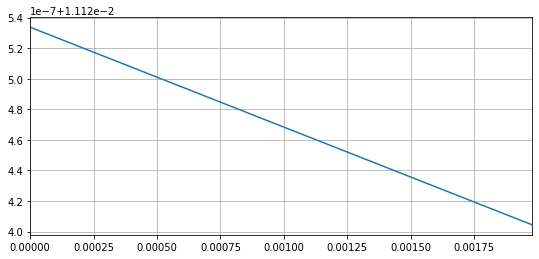

In [24]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.006972819010951972, R2: 0.9647055354758722


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 467.2228242061629, R2: 0.35956209036426445


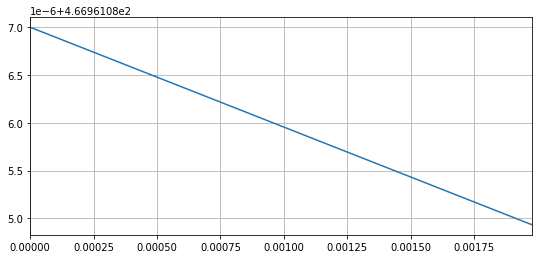

In [15]:
build_plot(X_train, y_train, X_val, y_val)

In [16]:
regr = GradientLR(0.1, iterations=10000, l=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 466.9609824838058, R2: 0.35961068037140576


In [17]:
# Для сравнения ошибки взял Lasso из sklearn

from sklearn.linear_model import Lasso

regr = Lasso(alpha=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 467.18876110688285, R2: 0.35951318333850724


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Описание признаков:

1. crim     per capita crime rate by town
2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus    proportion of non-retail business acres per town
4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox      nitric oxides concentration (parts per 10 million)
6. rm       average number of rooms per dwelling
7. age      proportion of owner-occupied units built prior to 1940
8. dis      weighted distances to five Boston employment centres
9. rad      index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in $'s


In [18]:
regr = GradientLR(0.1, iterations=10000, l=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 466.9609824838058, R2: 0.35961068037140576


In [20]:
import pandas as pd

feature_importance = [(k, v) for k, v in enumerate(abs(regr.W))]
feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'value'])
feature_importance = feature_importance.sort_values(by='value', ascending=False).reset_index(drop=True)

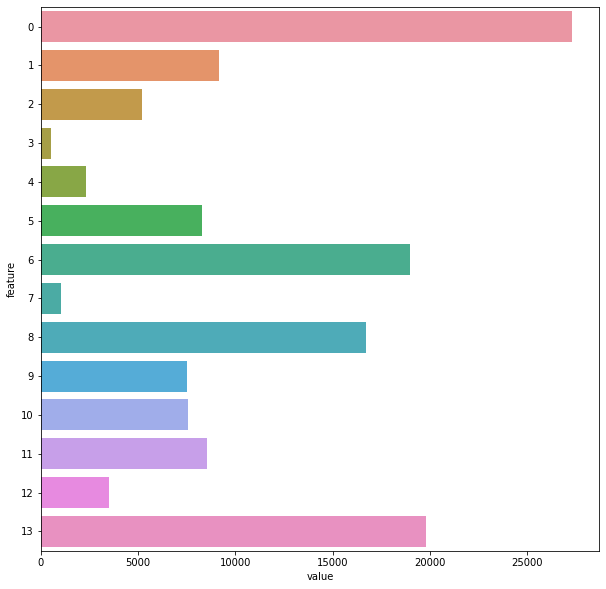

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
ax = sns.barplot(x='value', y='feature', data=feature_importance, orient='h');
plt.show()

In [22]:
x = [(k, v) for k, v in enumerate(regr.W)]

sorted(x, key=lambda item: -abs(item[1]))

[(0, 27337.841403754213),
 (13, -19785.48443570331),
 (6, 18990.975953505116),
 (8, -16736.96829303054),
 (1, -9144.52826255809),
 (11, -8545.358410423736),
 (5, -8308.964908902139),
 (10, -7580.48052337668),
 (9, 7507.797781003121),
 (2, 5195.906260689481),
 (12, 3482.694903394007),
 (4, 2321.3429377790803),
 (7, 1020.160375972524),
 (3, -507.4705906357491)]

Видно, что самый сильный признак - это признак 0. Он означает криминальный уровень по городу / району. Очевидно, что чем безопаснее район, тем большая цена за дом и тут есть прямая логическая зависимость.

Следующие по влиятельности признаки - это 13, 6 и 8.

13 - это "lower status of the population". Он также сильно влияет на таргет, но он обладает обратной корреляцией с таргетом.

6 признак - "proportion of owner-occupied units built prior to 1940". Также сильно влияет на таргет. Получается, что чем старше дом, тем он дороже."

8 признак - "index of accessibility to radial highways". Также влияет сильно доступность дома к магистралям.

Следующая группа "средне-значимых признаков" - это признаки 1, 11, 5, 10, 9. Причем признаки 1, 11, 5 и 10 отрицательно влияют на цену, 9, наоборот, положительно.

2 немного менее значительный.

А признаки 12, 4, 7 и 3 кажутся самыми бесполезнами.